In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
import stanza
import spacy

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

Ouvrir les CSV et diviser train en train et validation

In [6]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')
df_train 

,doc_id,titre,type,difficulte,cout,ingredients,recette
0,recette_221358.xml,"Feuilleté de saumon et de poireau, sauce aux c...",Plat principal,Facile,Moyen,- 1 gros pavé de saumon - 100 g de crevettes d...,Couper finement le blanc et un peu de vert des...
1,recette_48656.xml,Cake poulet/moutarde/amandes,Entrée,Très facile,Bon marché,- 3 œufs - 150 g de farine - 1 sachet de levur...,"Couper finement l'échalote, la faire revenir à..."
2,recette_30049.xml,Bûche à la truite fumée (7ème rencontre),Entrée,Moyennement difficile,Assez Cher,- 800 g de filet de truite saumonnée fumée en ...,Faites blanchir les épinards à l'eau bouillant...
3,recette_71424.xml,Gâteau au yaourt au coco sans huile de laetitia,Dessert,Très facile,Bon marché,- 1 pot de yaourt - 1 pot de lait de coco - 3 ...,Mélanger dans l'ordre tous les ingrédients en ...
4,recette_217204.xml,Crêpes au canard laqué,Entrée,Moyennement difficile,Moyen,- 90 g de farine - 45 g de maïzena - 2 œufs - ...,"Fouetter les œufs avec l'eau, le lait et le su..."
...,...,...,...,...,...,...,...
12468,recette_88545.xml,Tarte thon et courgettes,Plat principal,Facile,Bon marché,- 1 pâte feuilleté - 2 œufs - 2 courgettes moy...,"Couper les courgettes en fines rondelles, les ..."
12469,recette_36440.xml,Gratin de légumes à la viande,Plat principal,Facile,Bon marché,- 500 g de pommes de terre - 400 g de carotte...,Epluchez les pommes de terre et lavez-les. Cou...
12470,recette_174633.xml,Tagliatelles fraiches au Montepulciano,Plat principal,Difficile,Moyen,- Pour les tagliatelles : - 150 g de semoule f...,Je conseille de préparer les tagliatelles la v...
12471,recette_43030.xml,"Bavarois praliné pistache, coeur de mousse au ...",Dessert,Difficile,Assez Cher,- Pour le biscuit Dacquoise : - 160 g de blanc...,Petits commentaires :J'ai indiqué les recettes...


In [24]:
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)

In [25]:
df_train.to_csv("../data/train1.csv", index=False)
df_validation.to_csv("../data/validation.csv", index=False)

Prétraitement

In [50]:
# nlp = stanza.Pipeline(lang="en", processors="tokenize,lemma")
    
# def lemmatize(text):
#     doc = nlp(text)
#     lemmas = [
#         word.lemma
#         for sentence in doc.sentences
#         for word in sentence.words
#     ]
#     return " ".join(lemmas)

# # faire une boucle pour ne prendre qu'une recette à la fois
# for i in range(len(df_train)):
#     df_train["recette"][i] = df_train["recette"][i].lower()
#     df_train["recette"][i] = lemmatize(df_train["recette"][i])
    
# df_train.to_csv("../data/train_pre.csv", index=False)
nlp = spacy.load("fr_core_news_lg")

def clean_text(text):
    doc = nlp(text)
    words = [token.text for token in doc if not token.is_stop]
    return " ".join(words)

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_train['cleaned_text'] = df_train['text'].apply(clean_text)


OSError: [E050] Can't find model 'fr_core_news_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

In [54]:
df_train["text"] = df_train["titre"] + " " + df_train["recette"]
df_test["text"] = df_test["titre"] + " " + df_test["recette"]
df_validation["text"] = df_validation["titre"] + " " + df_validation["recette"]

print(len(df_train["text"]))
print(len(df_train["titre"]))
print(len(df_train["recette"]))


9978
9978
9978


Baseline (random?)

In [58]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(df_train['text'])
x_test = vectorizer.transform(df_test['text'])
x_validation = vectorizer.transform(df_validation['text'])

y_train = df_train['type']
y_test = df_test['type']
y_validation = df_validation['type']


Arbre de décision

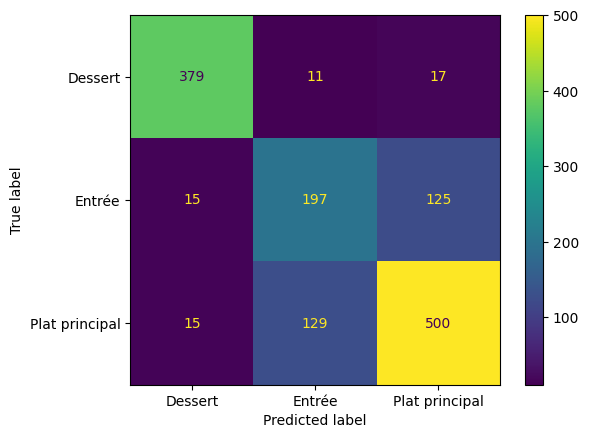

In [67]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

generate_confusion_matrix(predictions, y_test)


SVM

In [70]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

model = SVC(kernel='linear')
model.fit(x_train, y_train)

y_test = encoder.transform(y_test)
y_pred = model.predict(x_test)
#model_cleaned.fit(x_train_cleaned, y_train)

ValueError: invalid literal for int() with base 10: 'Dessert'

Random forest

In [ ]:
def random_forest(matrix, classes):
    rf_classifier = RandomForestClassifier()
    y_pred = cross_val_predict(rf_classifier, matrix, classes, cv=10)
    return y_pred

Naive Bayes

In [ ]:
def naive_bayes(matrix, classes):
    nb_classifier = MultinomialNB()
    y_pred = cross_val_predict(nb_classifier, matrix, classes, cv=10)
    return y_pred

In [62]:
def generate_confusion_matrix(prediction, classes):
    labels = sorted(list(set(classes)))
    cm = confusion_matrix(classes, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()